##### Model comparison for logistic fits to correlation task choice data.


Produces analyses associated with Fig 3.

Normative evidence weighting and accumulation in correlated environments. Tardiff et al. (2024).

Nathan Tardiff 05/28/24

In [1]:
imatlab_export_fig('print-svg')
set(0,'defaultfigurecolor',[1 1 1])
set(groot,'DefaultAxesFontName','Arial')


addpath('./logistic')

DATA_DIR = './data';
FIT_DIR = './logistic_fits';

fits(1).model_id = 1;
fits(1).fitmat = 'fits_lapse_separate_09-Aug-2023.mat';
fits(1).dmat_func = @make_basic_dmat;
fits(1).mname = 'separate';
fits(1).nparam = 3;

fits(2).model_id = 2;
fits(2).fitmat = 'fits_lapse_base_09-Aug-2023.mat';
fits(2).dmat_func = @make_basic_dmat;
fits(2).mname = 'base';
fits(2).nparam = 3;


data = readtable(fullfile(DATA_DIR,'all_parsed_data_2023-08-06.csv'));  
subj = unique(data.subject);
rho_conds = unique(data.rho_cond);

In [2]:
%% compute average data and set up variables

data_ave_subj = summary_stats(data,{'response'},...
    {'subject','rho_cond','rho','uSNR','SNR'});
data_ave_all = summary_stats(data_ave_subj,'mean_response',{'rho_cond','rho','uSNR'});


co = {'r','k','b'};


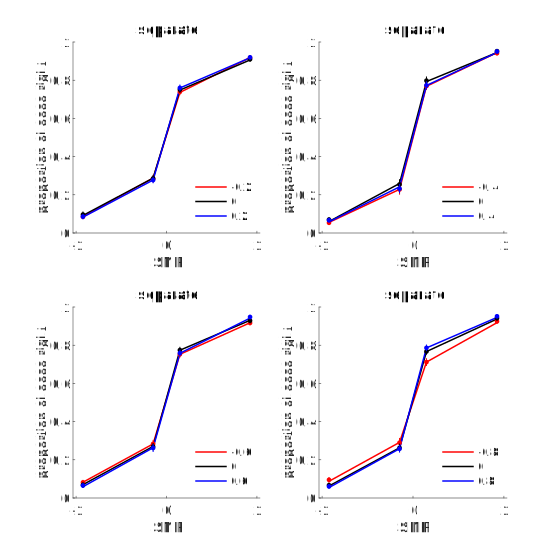

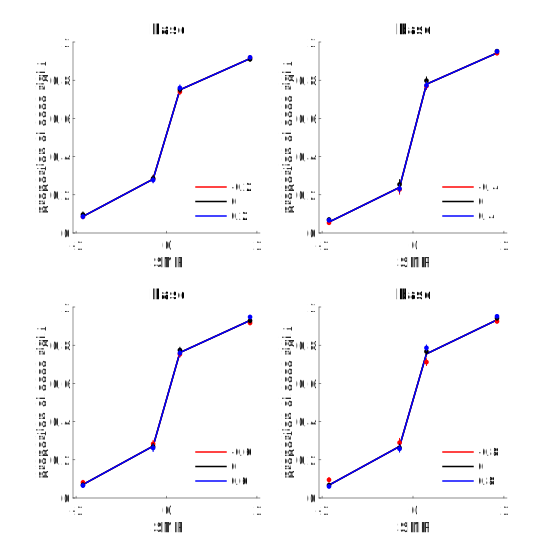

In [3]:
%compute and plot predictions for all logistic models
this_figdim = [1 1 560 560];
%this_subplot = @(m,n,p) subtightplot(m,n,p,.12,[.16 .05],[0.12 0.05]);
set(groot,'DefaultAxesFontSize',15)
set(groot,'DefaultLineLineWidth',1.5)
set(groot,'DefaultErrorBarLineWidth',1)
set(groot,'DefaultErrorBarMarkerSize',14)
set(groot,'DefaultErrorBarCapSize',0)
set(groot,'DefaultLegendBox','off')

psycho_fit_ave_out = [];
for m=1:length(fits)
    F = load(fullfile(FIT_DIR,fits(m).fitmat));
    this_dmat_func = fits(m).dmat_func;

    this_fits_pred = [];
    for s=1:length(subj)
        this_subj = subj{s};
        this_fits = F.fits_lapse(strcmp(F.fits_lapse.subject,this_subj),:); %,1:fits(m).nparam};
        assert(height(this_fits)==1 || height(this_fits)==3, 'Invalid number of fits detected!');
        if height(this_fits) == 3 %we need to process a fit for each rho cond
            this_sdata = [];
            for ff=1:height(this_fits)
                this_sdatai = data_ave_subj(strcmp(data_ave_subj.subject,this_subj) & ...
                    data_ave_subj.rho == this_fits.rho(ff),...
                    {'subject','rho_cond','rho','uSNR','SNR'});
                this_sdatai.pred = logist_pred(this_sdatai,...
                    this_fits{ff,1:fits(m).nparam},this_dmat_func,[],1);
                
                this_sdata = [this_sdata;this_sdatai];
                clear this_sdatai
            end
        else
            this_sdata = data_ave_subj(strcmp(data_ave_subj.subject,this_subj),...
                {'subject','rho_cond','rho','uSNR','SNR'});
            this_sdata.pred = logist_pred(this_sdata,...
                this_fits{:,1:fits(m).nparam},this_dmat_func,[],1);
        end

        this_fits_pred = [this_fits_pred;this_sdata];
    end
    

    this_fits_pred_ave_all = summary_stats(this_fits_pred,{'pred'},...
        {'rho_cond','rho','uSNR'});
    
    %save for output
    this_fits_pred_ave_all.model_id = repmat(fits(m).model_id,height(this_fits_pred_ave_all),1);
    this_fits_pred_ave_all.mname = repmat(cellstr(fits(m).mname),height(this_fits_pred_ave_all),1);
    psycho_fit_ave_out = [psycho_fit_ave_out;this_fits_pred_ave_all];

    figure('Position',this_figdim);hold on;
    %figure();hold on;
    for rr=1:length(rho_conds)
        subplot(2,2,rr)
        this_fits_pred_avei = this_fits_pred_ave_all(this_fits_pred_ave_all.rho_cond==rho_conds(rr),:);
        data_ave_alli = data_ave_all(data_ave_all.rho_cond==rho_conds(rr),:);
        psycho_plot(this_fits_pred_avei ,'rho',strcat('-',co),...
            'mean_pred',[],0,'uSNR');
        psycho_plot(data_ave_alli,'rho',strcat('.',co),...
            'mean_mean_response','sem_mean_response',0,'uSNR');

        xlabel('SNR')
        ylabel('proportion choose right')
        ylim([0 1])
        title(fits(m).mname)
        this_leg = arrayfun(@num2str,unique(this_fits_pred_avei.rho),'UniformOutput',false);
        legend(this_leg,'Location','SouthEast')
    end
end
set(groot,'DefaultAxesFontSize','factory')
set(groot,'DefaultLineLineWidth','factory')
set(groot,'DefaultErrorBarLineWidth','factory')
set(groot,'DefaultErrorBarMarkerSize','factory')
set(groot,'DefaultErrorBarCapSize','factory')
set(groot,'DefaultLegendBox','factory')

In [4]:
%% load in fit data

lle = table();
for i=1:length(fits)
    F = load(fullfile(FIT_DIR,fits(i).fitmat));
    fit_statsi = F.fit_stats;
    
    if strcmp(fit_statsi.mname,'separate')        
        %we need to combine the fit stats across rhos for comparison
        fit_statsi = varfun(@sum,fit_statsi,'InputVariables',{'LL','nparam'},...
            'GroupingVariables',{'subject','mname','model_id','rho_cond'});
        fit_statsi.GroupCount = [];
        fit_statsi.Properties.VariableNames = strrep(fit_statsi.Properties.VariableNames,'sum_','');
    else
        %keep only fields we need and make it match separate after the
        %summing
        fit_statsi = fit_statsi(:,{'subject','mname','model_id','rho_cond','LL','nparam'});
    end
    lle = [lle; fit_statsi];
    clear F
end

%compute AIC
lle.aic = 2.*lle.nparam - 2.*lle.LL;


lle_ave =

  2x10 table

    model_id       mname        nparam    GroupCount    mean_LL    mean_aic    std_LL    std_aic    sem_LL    sem_aic
    ________    ____________    ______    __________    _______    ________    ______    _______    ______    _______

       1        {'separate'}      9          100        -296.77     611.54     61.412    122.82     6.1412    12.282 
       2        {'base'    }      3          100         -300.7     607.41     61.428    122.86     6.1428    12.286 


delta_AIC =

   -4.1378



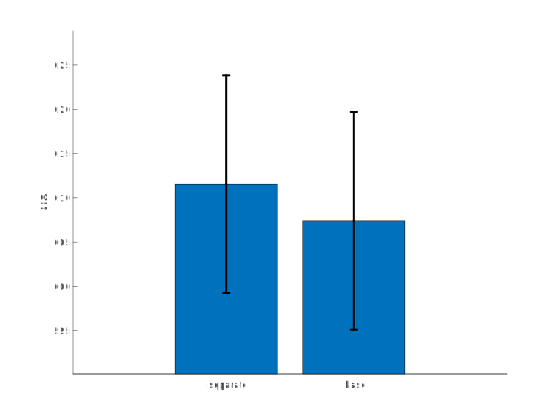

In [5]:
lle_ave = summary_stats(lle,{'LL','aic'},{'model_id','mname','nparam'})

barplot(lle_ave.mean_aic,lle_ave.sem_aic,'xticklabel',{'separate','base'},'ylabel','AIC');
ylim([min(lle_ave.mean_aic) - max(lle_ave.sem_aic)-5,...
    max(lle_ave.mean_aic) + max(lle_ave.sem_aic)+5])
delta_AIC = diff(lle_ave.mean_aic)

---
Date: 28-May-2024 15:00:30
VB converged in 11 iterations (took ~3 sec).
Dimensions:
     - subjects: n=100
     - models: K=2
Posterior probabilities:
     - RFX: p(H1|y)= 1.000
     - null: p(H0|y)= 0.000

ans =

  2x3 table

       mname           Ef          pep    
    ____________    ________    __________

    {'base'    }     0.90633             1
    {'separate'}    0.093668    5.3237e-11



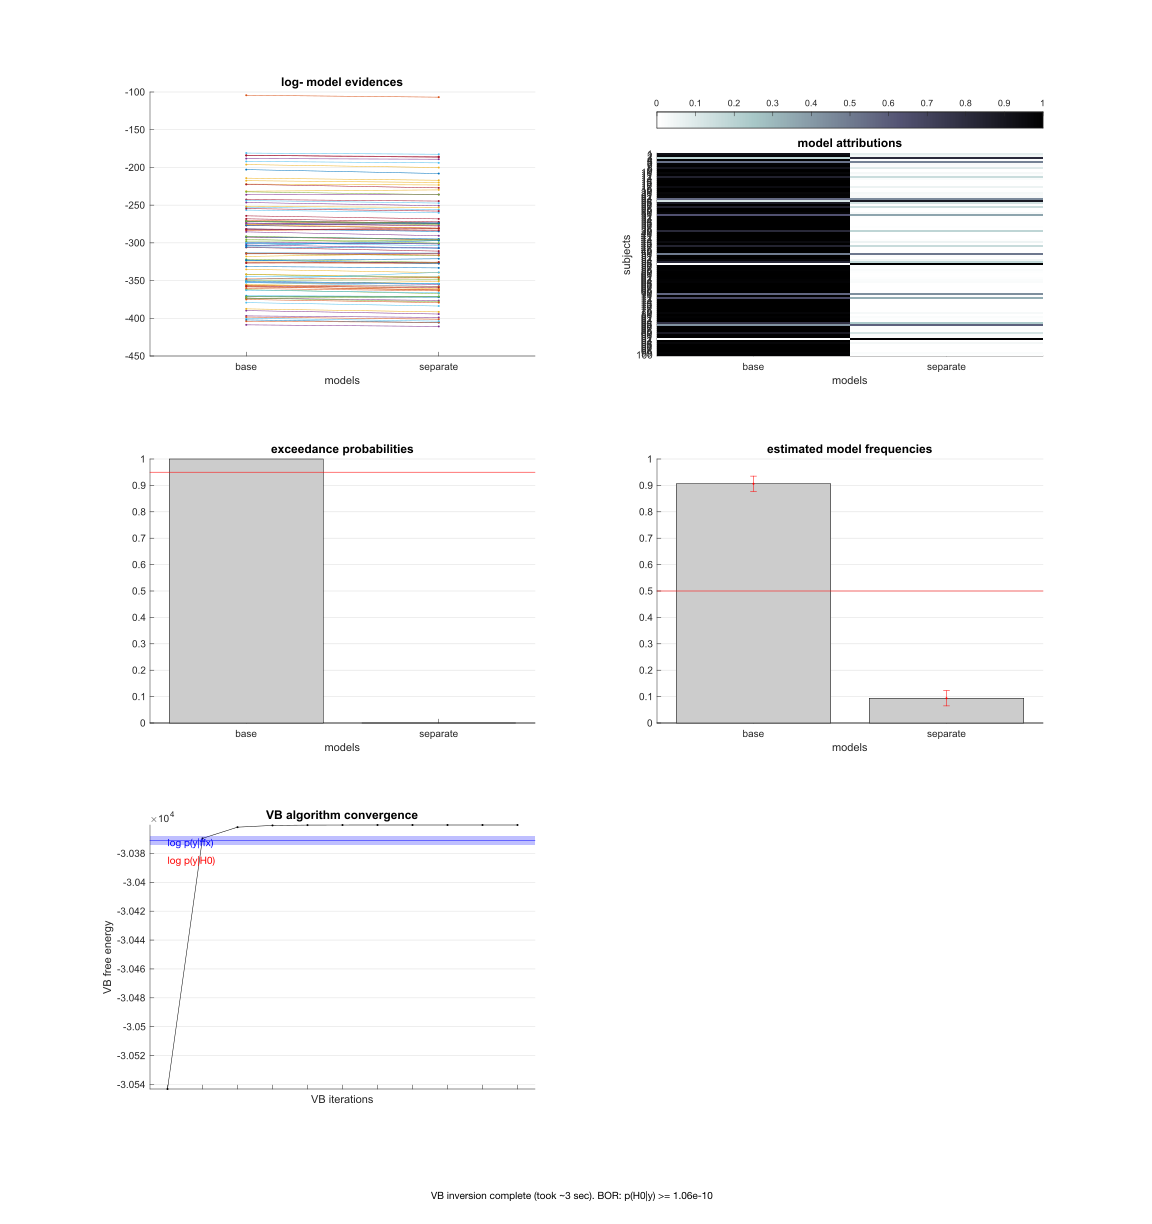

In [6]:
%% now let's look at exceedance probability
lle_VBA = lle(:,{'subject','mname','aic'});
%Stephan et al 2009 AIC is normal AIC/-2 ie log(lle) - k; this is what
%the BMC function expects 
lle_VBA.aic = lle_VBA.aic./-2;
lle_VBA = unstack(lle_VBA,'aic','mname');

opts.MaxIter = 1e4;
opts.modelNames = lle_VBA.Properties.VariableNames(2:end);

[posterior,out] = VBA_groupBMC(lle_VBA{:,2:end}',opts);
%compute protected EP: Rigoux et al., 2014. Code from:
%http://mbb-team.github.io/VBA-toolbox/wiki/BMS-for-group-studies/
out.PEP = (1-out.bor)*out.ep + out.bor/length(out.ep);

out_table = table(out.options.modelNames',out.ep',out.PEP',out.Ef,...
    'VariableNames',{'mname','ep','pep','Ef'});

out_table(:,{'mname','Ef','pep'})

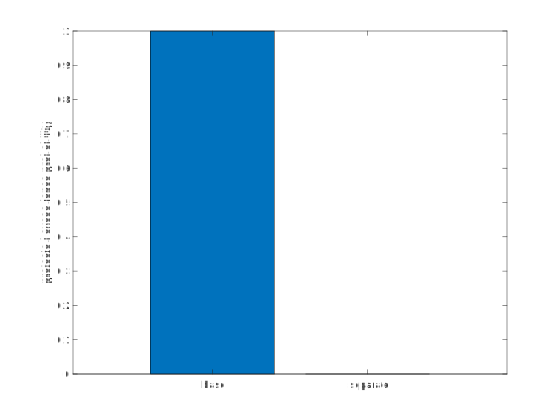

In [7]:
%plot protected exceedance probabilities
figure();bar(categorical(out_table.mname),out_table.pep)
%xticklabels({'full','shared slopes','base','adapt'})
ylabel('protected exceedance probability')

In [8]:
%% does this look any different by rho cond? Not by AIC...

lle_ave_rho = summary_stats(lle,{'LL','aic'},{'rho_cond','model_id','mname','nparam'});
lle_ave_rho(:,{'rho_cond','mname','nparam','mean_aic'})

lle_ave_rhoW = unstack(lle_ave_rho(:,{'rho_cond','mname','mean_aic'}),{'mean_aic'},'mname');
lle_ave_rhoW.deltaAIC = lle_ave_rhoW.base - lle_ave_rhoW.separate;
lle_ave_rhoW


ans =

  8x4 table

    rho_cond       mname        nparam    mean_aic
    ________    ____________    ______    ________

      0.2       {'separate'}      9         657.7 
      0.2       {'base'    }      3        651.08 
      0.4       {'separate'}      9        559.67 
      0.4       {'base'    }      3        555.54 
      0.6       {'separate'}      9        620.17 
      0.6       {'base'    }      3        616.43 
      0.8       {'separate'}      9        608.64 
      0.8       {'base'    }      3        606.57 


lle_ave_rhoW =

  4x4 table

    rho_cond     base     separate    deltaAIC
    ________    ______    ________    ________

      0.2       651.08      657.7     -6.6161 
      0.4       555.54     559.67     -4.1281 
      0.6       616.43     620.17     -3.7373 
      0.8       606.57     608.64     -2.0698 



---
Date: 28-May-2024 15:00:34
VB converged in 7 iterations (took ~1 sec).
Dimensions:
     - subjects: n=25
     - models: K=2
Posterior probabilities:
     - RFX: p(H1|y)= 1.000
     - null: p(H0|y)= 0.000

ans =

  2x4 table

    rho_cond       mname           Ef          pep    
    ________    ____________    ________    __________

      0.2       {'base'    }      0.9798             1
      0.2       {'separate'}    0.020202    2.0488e-06

---
Date: 28-May-2024 15:00:37
VB converged in 17 iterations (took ~2 sec).
Dimensions:
     - subjects: n=25
     - models: K=2
Posterior probabilities:
     - RFX: p(H1|y)= 0.997
     - null: p(H0|y)= 0.003

ans =

  2x4 table

    rho_cond       mname          Ef         pep   
    ________    ____________    _______    ________

      0.4       {'base'    }    0.96325     0.99868
      0.4       {'separate'}    0.03675    0.001324

---
Date: 28-May-2024 15:00:39
VB converged in 10 iterations (took ~1 sec).
Dimensions:
     - subjects: n=25

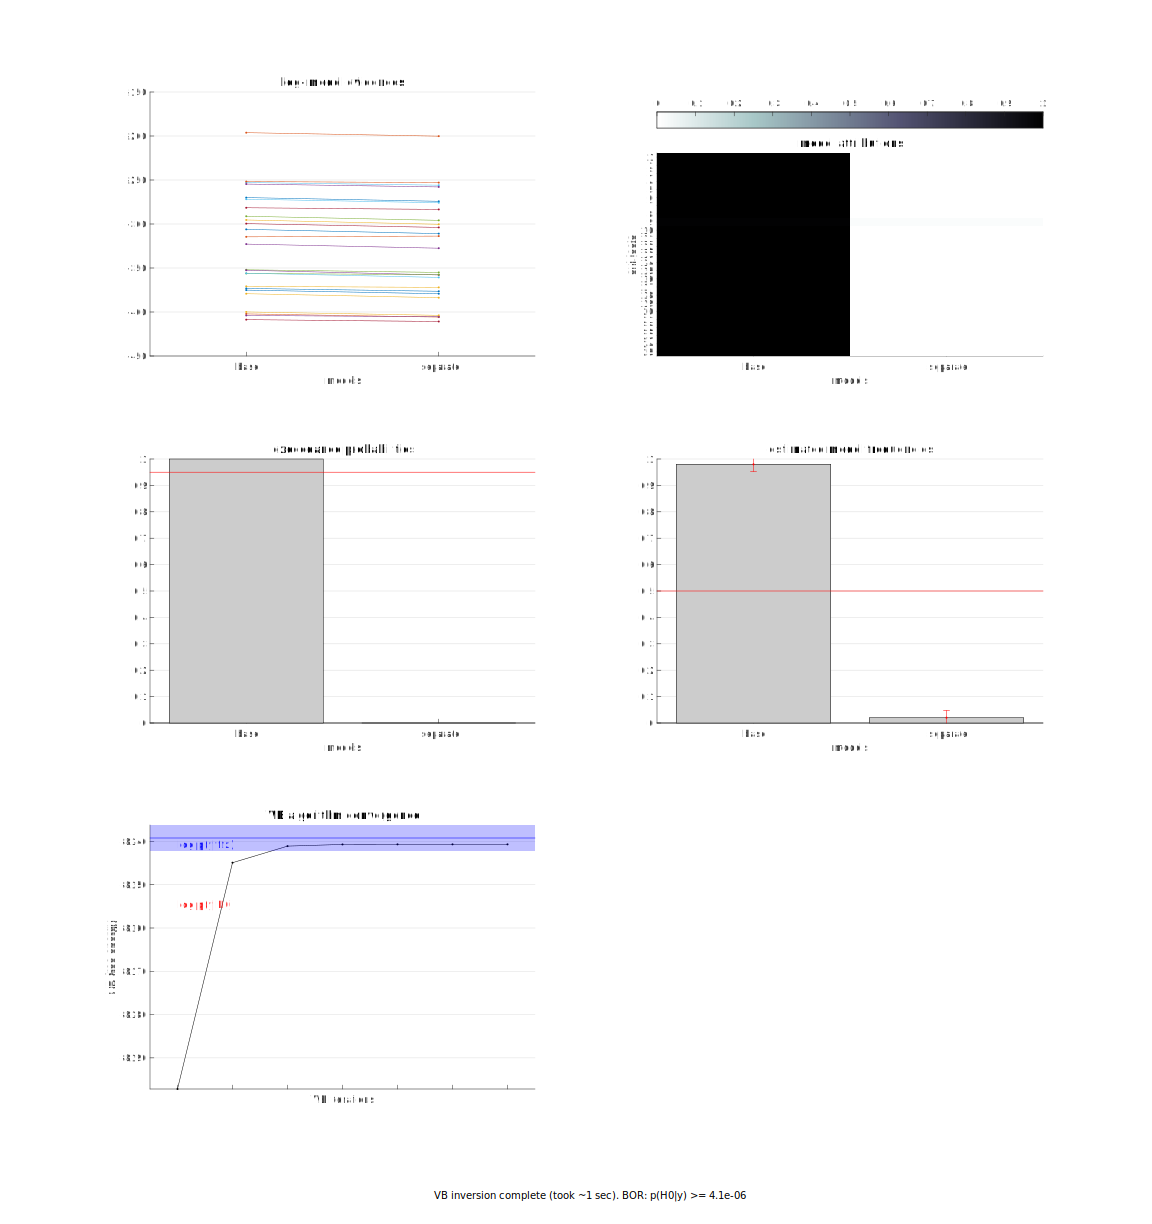

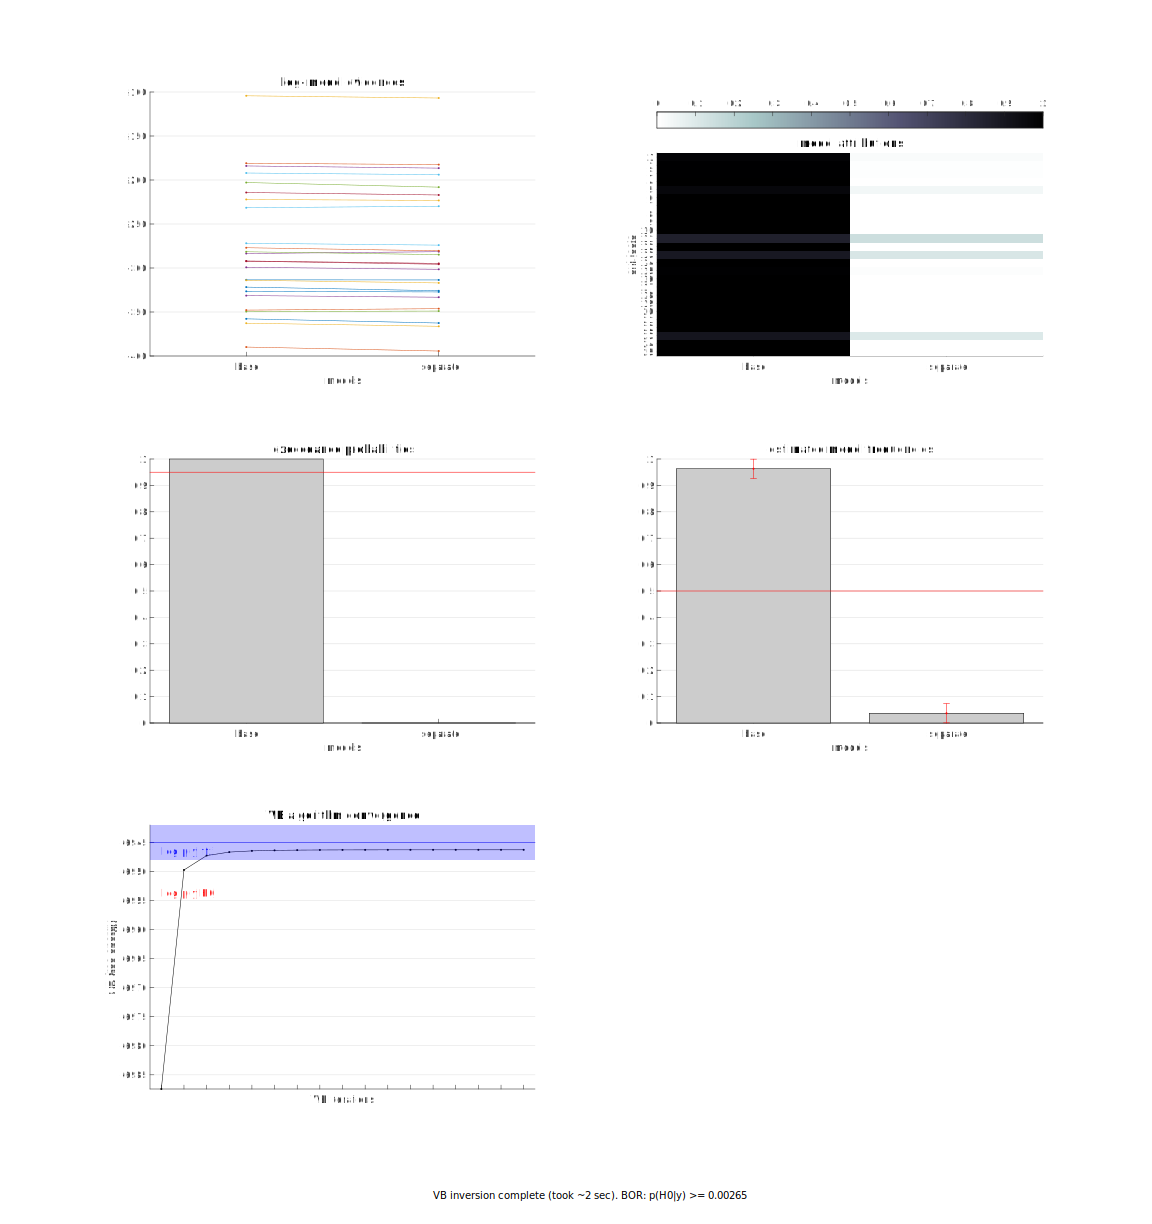

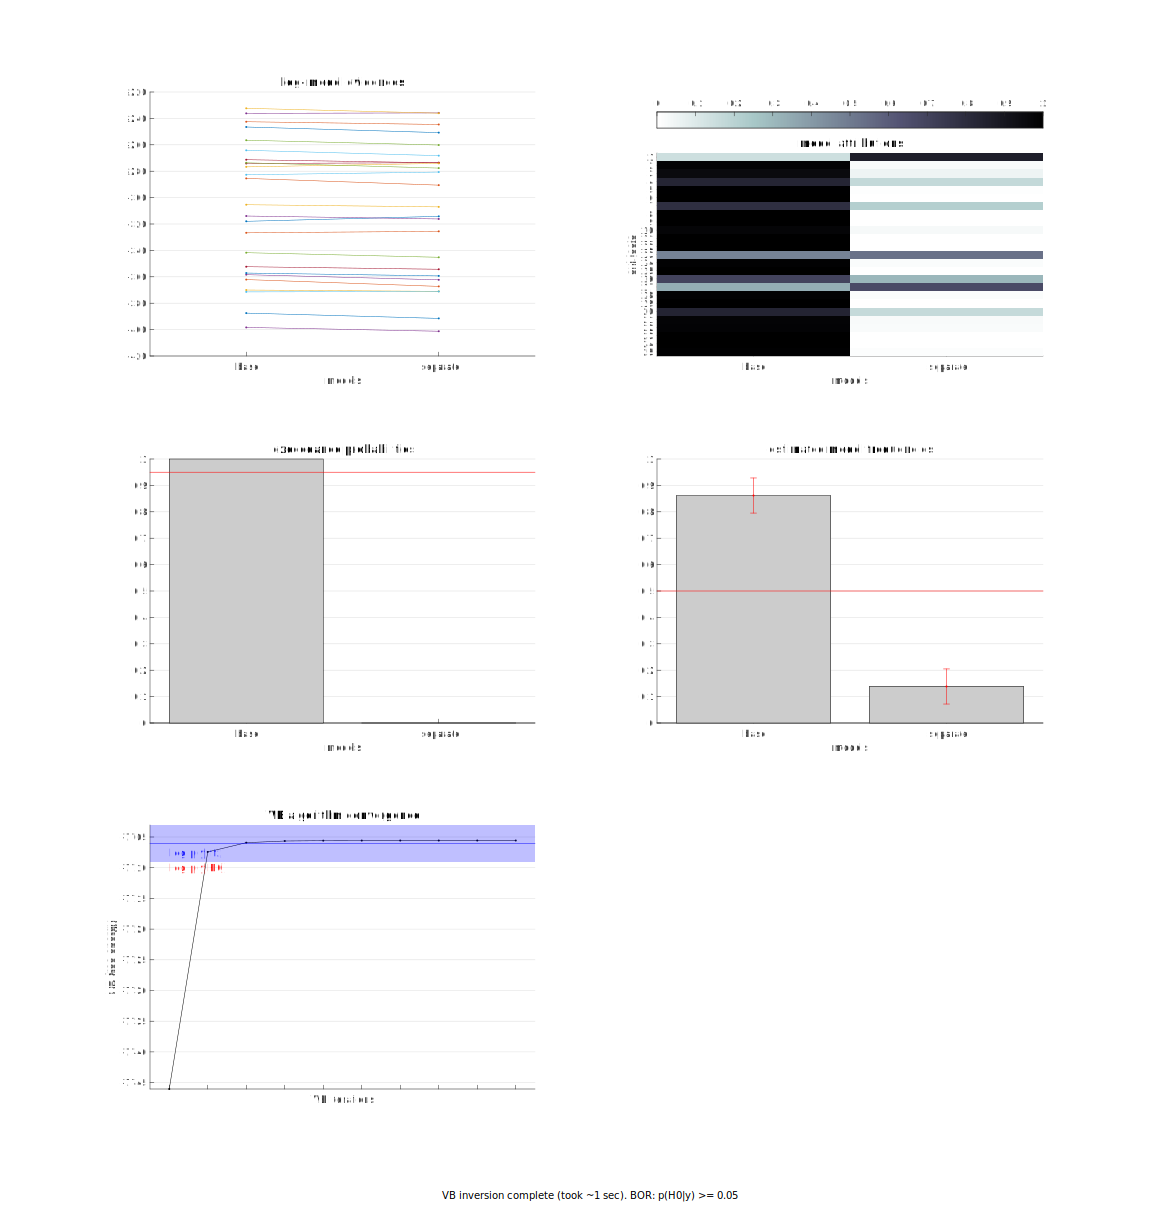

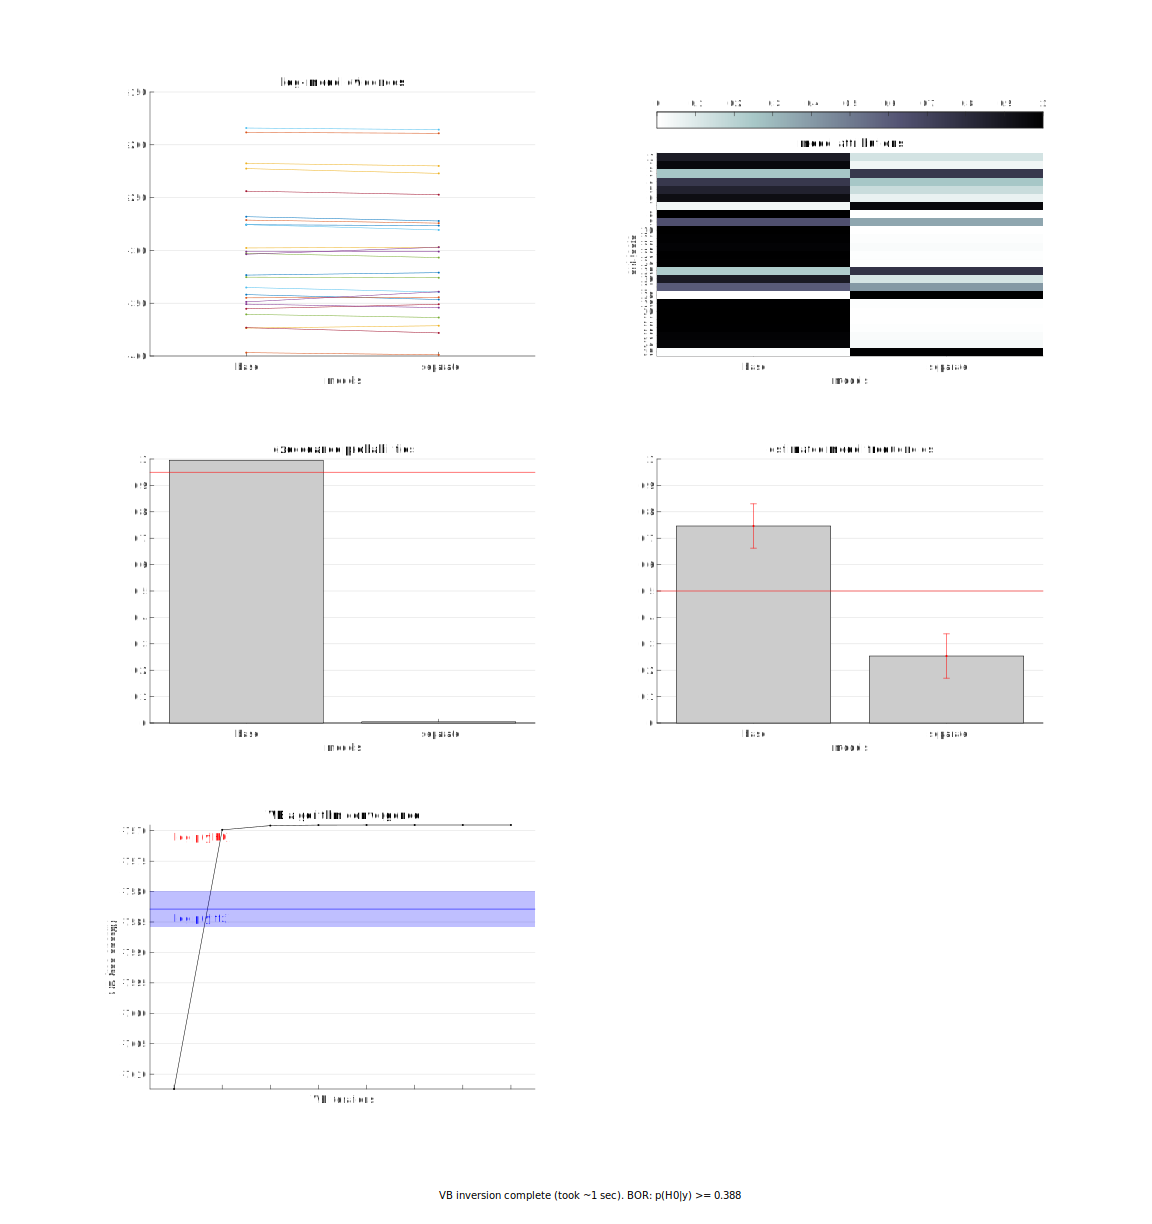

In [9]:
%% now let's look at exceedance probability x rho
for rr=1:length(rho_conds)
    %disp(rho_conds(rr))
    lle_VBA = lle(lle.rho_cond==rho_conds(rr),{'subject','mname','aic'});
    %Stephan et al 2009 AIC is normal AIC/-2 ie log(lle) - k; this is what
    %the BMC function expects 
    lle_VBA.aic = lle_VBA.aic./-2;
    lle_VBA = unstack(lle_VBA,'aic','mname');

    opts.MaxIter = 1e4;
    opts.modelNames = lle_VBA.Properties.VariableNames(2:end);

    [posterior,out] = VBA_groupBMC(lle_VBA{:,2:end}',opts);
    %compute protected EP: Rigoux et al., 2014. Code from:
    %http://mbb-team.github.io/VBA-toolbox/wiki/BMS-for-group-studies/
    out.PEP = (1-out.bor)*out.ep + out.bor/length(out.ep);

    out_table = table(repmat(rho_conds(rr),length(out.ep),1),out.options.modelNames',out.ep',out.PEP',out.Ef,...
        'VariableNames',{'rho_cond','mname','ep','pep','Ef'});

    out_table(:,{'rho_cond','mname','Ef','pep'})
end